In [19]:
import lsst.daf.base as dafBase
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import Utils.DiaSourceTools as DSTools
from astropy.table import Column
from lsst.ip.diffim import GetCoaddAsTemplateTask, GetCalexpAsTemplateTask

In [2]:

DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/output/classTest"
butler = dafPersist.Butler(DATADIR)

DATADIR_2="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/output/"
butler_2 = dafPersist.Butler(DATADIR_2)

In [3]:
def multi_match_catalogs(catalog_list, data_refs):
    multi_matches = None

    for catalog, (visit, ccd) in zip(catalog_list, data_refs):

            if multi_matches is None and len(catalog)>0:
                multi_matches = afwTable.MultiMatch(catalog[0].schema, {'visit':int, 'ccd':int}, radius=afwGeom.Angle(1./3600., afwGeom.degrees))
            if multi_matches is not None:
                multi_matches.add(catalog, {'visit':int(visit), 'ccd':int(ccd)})

    results = multi_matches.finish(removeAmbiguous=False)  
    return results

In [4]:
data_refs = butler.queryMetadata("deepDiff_class_diaSrc", format=['visit', 'ccd'], dataId={'filter':'r'})
def_data_refs = []
catalogs = []
for data_ref in data_refs:
    if butler.datasetExists("deepDiff_class_diaSrc", dataId={'visit':data_ref[0], 'ccd':data_ref[1], 'filter':'r'}):
        catalog = butler.get("deepDiff_class_diaSrc", dataId={'visit':data_ref[0], 'ccd':data_ref[1], 'filter':'r'})
        catalogs.append(catalog)
        def_data_refs.append(data_ref)
        

    

In [5]:
results = multi_match_catalogs(catalogs, def_data_refs)

In [6]:
light_curves=DSTools.get_light_curves_from_multimatch_results2(results)
print len(light_curves)

287100


In [77]:
t_light_curves = DSTools.threshold_light_curves(light_curves, 25)
print len(t_light_curves)

3937


In [8]:
lcs_completes = []
for light_curve in t_light_curves:
    lcs_completes.append(DSTools.build_lightcurve2(light_curve, "base_CircularApertureFlux_4_5_flux"))

In [9]:
import pickle 
pkl_file = open('mjd_dict.pickle', 'rb')
mjds = pickle.load(pkl_file)

In [ ]:
output = open('/renoir_data_02/jpreyes/stamp_data/light_curves_total.pickle', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(lcs_completes, output)
output.close()

In [10]:

lcs = []
for light_curve in t_light_curves:
    lcs.append(DSTools.build_lightcurve2(light_curve, "base_CircularApertureFlux_4_5_flux"))

In [11]:

for lc in lcs:
    try:
        lc.add_column(Column(name="visit", data=lc["mjd"].data))
        lc.replace_column("mjd", lc["mjd"].astype(float))

        for point in lc:        
            point["mjd"] = float(mjds[str(int(point["mjd"]))])
    except Exception, e:
        print e
    
    


In [ ]:
import pickle

output = open('/renoir_data_02/jpreyes/stamp_data/light_curves_25.pickle', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(lcs, output)
output.close()

In [12]:

for lc in lcs:
    try:
        #lc.add_column(Column(name="visit", data=lc["mjd"].data))
        lc.replace_column("ra", lc["ra"].astype(float))
        lc.replace_column("dec", lc["dec"].astype(float))

       
    except Exception, e:
        print e
    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
lc = lcs[2700]
stamps = get_stamps_in_lc(lc)
%matplotlib inline
stamp, c_stamp = stamps[2]

In [ ]:
vmin= c_img_arr.min()- c_img_arr.std()

vmax=c_img_arr.max()+c_img_arr.std()

In [ ]:
for point, (stamp, c_stamp) in zip(lc, stamps):
    if stamp is not None:
        img_arr, mask_arr, var_arr = stamp.getMaskedImage().getArrays()
        c_img_arr, c_mask_arr, c_var_arr = c_stamp.getMaskedImage().getArrays()
        w,h = stamp.getWidth(), stamp.getHeight()  
        print(point['mjd'])
        plt.subplot(1,2,1)
        plt.imshow(img_arr, origin='lower', vmin=img_arr.mean()-img_arr.std(), vmax=img_arr.max()+img_arr.std(), cmap='gray', extent=(0,w-1, 0, h-1), interpolation='none')
        plt.subplot(1,2,2)
        plt.imshow(c_img_arr, origin='lower', vmin=vmin, vmax=vmax, cmap='gray', extent=(0,w-1, 0, h-1), interpolation='none')
        plt.show()

In [ ]:
visits, fluxes = get_fluxes_in_lc(lc)

In [ ]:
plt.scatter(visits, fluxes)
plt.ylim(ymin=0)

In [14]:
def get_fluxes_in_lc(lc):
    ccds= range(0,36)
    visits = []
    fluxes = []
    CenterRa = np.mean(lc["ra"])
    CenterDec = np.mean(lc["dec"])
    for point in lc:
      

        sources = butler.get("src", dataId={"filter":'r', 'visit':point["visit"], 'ccd':point["ccd"]})
        for src in sources:
            if DSTools.source_distance(point, {'ra':src['coord_ra'], 'dec':src['coord_dec']}) < 1:
                visits.append(point["mjd"])
                fluxes.append(src["base_PsfFlux_flux"])
                break
                



  
    return visits, fluxes

In [17]:



def get_stamps_in_lc(lc):
    ccds= range(0,36)
    stamps = []
    CenterRa = afwGeom.Angle(np.mean(lc["ra"])) 
    CenterDec = afwGeom.Angle(np.mean(lc["dec"]))
    for point in lc:
        
        data_id = {"filter":'r', 'visit':point["visit"], 'ccd':point["ccd"]}

        diffExp = butler.get("deepDiff_differenceExp", dataId=data_id)
        box = diffExp.getBBox()
        wcs = diffExp.getWcs()
        
        coord = afwGeom.Point2I(wcs.skyToPixel(CenterRa, CenterDec))
        #calexp = butler.get("calexp", dataId={"filter":'r', 'visit':point["mjd"], 'ccd':ccd})
        
    
        
        calexp = butler_2.get("calexp", dataId=data_id)

        gtTask = GetCoaddAsTemplateTask()
        
        dr = butler_2.dataRef("calexp", dataId=data_id)
        results = gtTask.run( calexp, dr)
        
        
        refexp = warper.warpExposure(calexp.getWcs(), results.exposure, destBBox=calexp.getBBox())
        

        Center = afwGeom.Point2I(wcs.skyToPixel(CenterRa, CenterDec))
        Begin = afwGeom.Point2I(Center.getX() - 15, Center.getY() - 15)
        End = afwGeom.Point2I(Center.getX() + 15, Center.getY() + 15)
        
        

        newBox = afwGeom.Box2I(Begin,End) 
        try:
            cal_stamp = calexp.Factory(calexp, newBox, True)
            ref_stamp = refexp.Factory(refexp, newBox, True)
            stamp = diffExp.Factory(diffExp,newBox, True)
            
            stamps.append((stamp, cal_stamp, ref_stamp))
        except Exception, e:
            print e
            stamps.append((None, None, None))
            pass
        
    return stamps

In [ ]:
def generate_patches(butler, lc, lc_id):
    
    import numpy as np
    import lsst.daf.base as dafBase
    import lsst.daf.persistence as dafPersist
    import lsst.afw.table as afwTable
    import lsst.afw.geom as afwGeom
    import Utils.DiaSourceTools as DSTools
    path = "/renoir_data_02/jpreyes/stamp_data/filter_r/"
    CenterRa = np.mean(lc["ra"])
    CenterDec = np.mean(lc["dec"])
    for i, point in enumerate(lc):

        data_id = {"filter":'r', 'visit':point["visit"], 'ccd':point["ccd"]}
        
        diffExp = butler.get("deepDiff_differenceExp", dataId=data_id)
        box = diffExp.getBBox()
        wcs = diffExp.getWcs()
        coord = afwGeom.Point2I(wcs.skyToPixel(CenterRa, CenterDec))
        #calexp = butler.get("calexp", dataId={"filter":'r', 'visit':point["mjd"], 'ccd':ccd})
        calexp = butler.get("calexp", dataId=data_id)
        
        
        #gtTask = GetCoaddAsTemplateTask()
        #newBox = afwGeom.Box2I(Begin,End) 
        #dr = butler.dataRef("calexp", dataId=data_id)
        #results = gtTask.run( calexp, dr)
        #refexp = results.exposure

        Center = afwGeom.Point2I(wcs.skyToPixel(CenterRa, CenterDec))
        Begin = afwGeom.Point2I(Center.getX() - 16, Center.getY() - 16)
        End = afwGeom.Point2I(Center.getX() + 15, Center.getY() + 15)

        
        try:
            cal_stamp = calexp.Factory(calexp, newBox, True)
            stamp = diffExp.Factory(diffExp,newBox, True)            
            name = str(lc_id)+"-"+str(i)
            stamp.writeFits(path+"diff-"+name+".fits")
            cal_stamp.writeFits(path+"cal-"+name+".fits")
            
        except Exception, e:
            print e
            pass
        
        
        
    
    

In [ ]:
import ipyparallel as ipyp

c = ipyp.Client()
v = c[:]
v = c.load_balanced_view()


res = v.map(lambda x,y: x+y, range(10), range(10))

print v
print res.get()

In [ ]:
test_lcs = lcs
size = len(test_lcs)
butlers = [butler]*size
lc_ids = range(size)
print len(test_lcs), len(butlers), len(lc_ids)

In [ ]:
res = v.map(generate_patches, butlers, lcs, lc_ids)

In [ ]:
print res.get()

In [ ]:
lc = lcs[0]
lc_id = 0
path = "/renoir_data_02/jpreyes/stamp_data/filter_r/"
CenterRa = np.mean(lc["ra"])
CenterDec = np.mean(lc["dec"])
for i, point in enumerate(lc):


    diffExp = butler.get("deepDiff_differenceExp", dataId={"filter":'r', 'visit':point["mjd"], 'ccd':point["ccd"]})
    box = diffExp.getBBox()
    wcs = diffExp.getWcs()
    coord = afwGeom.Point2I(wcs.skyToPixel(CenterRa, CenterDec))
    #calexp = butler.get("calexp", dataId={"filter":'r', 'visit':point["mjd"], 'ccd':ccd})
    calexp = butler.get("calexp", dataId={"filter":'r', 'visit':point["mjd"], 'ccd':point["ccd"]})


    Center = afwGeom.Point2I(wcs.skyToPixel(CenterRa, CenterDec))
    Begin = afwGeom.Point2I(Center.getX() - 16, Center.getY() - 16)
    End = afwGeom.Point2I(Center.getX() + 15, Center.getY() + 15)

    newBox = afwGeom.Box2I(Begin,End) 

    try:
        cal_stamp = calexp.Factory(calexp, newBox, True)
        stamp = diffExp.Factory(diffExp,newBox, True)            
        name = str(lc_id)+"-"+str(i)+"-"+str(point["mjd"])+"-"+str(int(point["classification"]))
        stamp.writeFits(path+name+".fits")

    except Exception, e:
        print e
        pass


In [ ]:
import pickle
output = open('/renoir_data_02/jpreyes/stamp_data/lcs6sigma.pickle', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(lcs, output)
output.close()

In [ ]:
v = lc[0]["visit"]
ccd = lc[0]["ccd"]

In [ ]:
gtTask = GetCoaddAsTemplateTask()

DATADIR_2="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/output/"
butler = dafPersist.Butler(DATADIR_2)

DATA_ID = {"filter":'r', 'visit':v, 'ccd':15}
calexp = butler.get("calexp", dataId=DATA_ID)

dr = butler.dataRef("calexp", dataId=DATA_ID)
results = gtTask.run( calexp, dr)

In [ ]:
ref = results.exposure

In [21]:
def initialize_warper():
    import lsst.pex.config as pexConfig
    from lsst.ip.diffim.psfMatch import PsfMatchTask, PsfMatchConfigDF, PsfMatchConfigAL
    from lsst.meas.algorithms import SourceDetectionTask, getBackground
    from lsst.meas.base import SingleFrameMeasurementTask
    import lsst.afw.math as afwMath

    class ImagePsfMatchConfig(pexConfig.Config):
        """!Configuration for image-to-image Psf matching"""
        kernel = pexConfig.ConfigChoiceField(
            doc="kernel type",
            typemap=dict(
                AL=PsfMatchConfigAL,
                DF=PsfMatchConfigDF
            ),
            default="AL",
        )
        selectDetection = pexConfig.ConfigurableField(
            target=SourceDetectionTask,
            doc="Initial detections used to feed stars to kernel fitting",
        )
        selectMeasurement = pexConfig.ConfigurableField(
            target=SingleFrameMeasurementTask,
            doc="Initial measurements used to feed stars to kernel fitting",
        )

        def setDefaults(self):
            # High sigma detections only
            self.selectDetection.reEstimateBackground = False
            self.selectDetection.thresholdValue = 10.0

            # Minimal set of measurments for star selection
            self.selectMeasurement.doApplyApCorr = "no"
            self.selectMeasurement.algorithms.names.clear()
            self.selectMeasurement.algorithms.names = ('base_SdssCentroid', 'base_PsfFlux', 'base_PixelFlags',
                                                       'base_SdssShape', 'base_GaussianFlux', 'base_SkyCoord')
            self.selectMeasurement.slots.modelFlux = None
            self.selectMeasurement.slots.apFlux = None
            self.selectMeasurement.slots.calibFlux = None
          
    config = ImagePsfMatchConfig()
    kConfig = config.kernel.active
    warper = afwMath.Warper.fromConfig(kConfig.warpingConfig)
    return warper



In [22]:
warper = initialize_warper()

In [ ]:
image_sci = calexp.getMaskedImage().getImage().getArray()
#r.getArray()
#image_ref = np.fliplr(np.flipud(image_ref))

image_ref = warp(calexp, results).getMaskedImage().getImage().getArray()
#image_ref = results.exposure.getMaskedImage().getImage().getArray()

In [ ]:
%matplotlib inline

fig = plt.figure(figsize = (20,20))
fig.add_subplot(1, 2, 1)  # this line outputs images side-by-side
plt.imshow(image_sci, cmap = 'gray', vmin=image_sci.mean()-image_sci.std(), vmax=image_sci.mean()+image_sci.std(), origin='lower')
plt.title('ReferenceImage', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
fig.add_subplot(1, 2, 2)  # this line outputs images side-by-side
plt.imshow(image_ref,  cmap = 'gray', vmin=image_ref.mean()-image_ref.std(), vmax=image_ref.mean()+image_ref.std(), origin='lower')
plt.title('NewImage', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [28]:
import numpy as np
import matplotlib.pyplot as plt
lc = lcs[1000]
stamps = get_stamps_in_lc(lc)



  File "src/image/Image.cc", line 92, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_view<boost::gil::memory_based_2d_locator<boost::gil::memory_based_step_iterator<boost::gil::pixel<float, boost::gil::layout<boost::mpl::vector1<boost::gil::gray_color_t> > >*> > >; lsst::afw::geom::Extent2I = lsst::afw::geom::Extent<int, 2>]
    Box2I(Point2I(2019,1093),Extent2I(31,31)) doesn't fit in image 2048x4612 {0}
lsst::pex::exceptions::LengthError: 'Box2I(Point2I(2019,1093),Extent2I(31,31)) doesn't fit in image 2048x4612'


  File "src/image/Image.cc", line 92, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_vie

In [49]:
10*len(in_stamps)

400

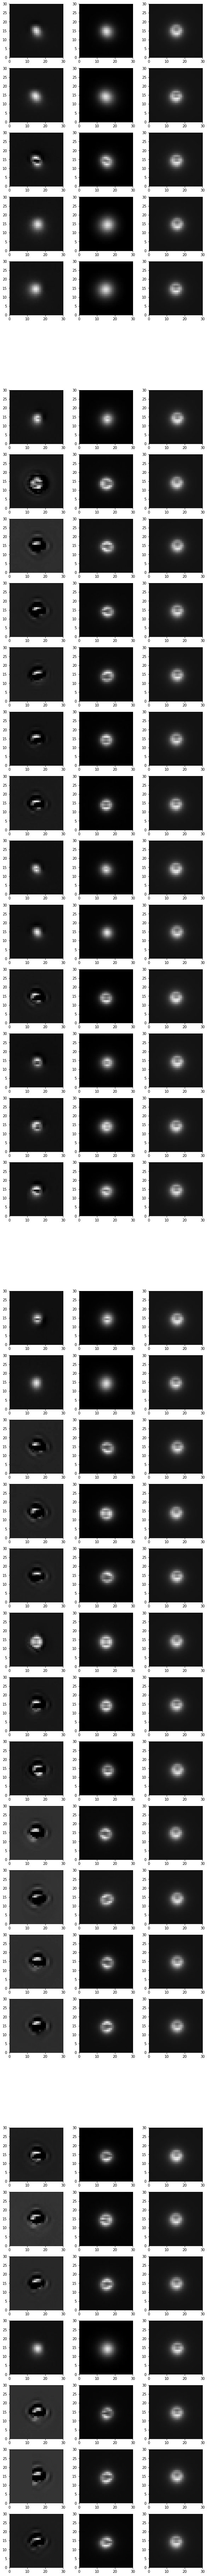

In [54]:
%matplotlib inline
in_stamps = stamps
plt.figure(figsize=(10,10*len(in_stamps)))
for i, (stamp, c_stamp, r_stamp) in enumerate(in_stamps):
    if stamp is not None:
        a = i+1
        img_arr, mask_arr, var_arr = stamp.getMaskedImage().getArrays()
        img_arr = np.nan_to_num(img_arr)
        c_img_arr, c_mask_arr, c_var_arr = c_stamp.getMaskedImage().getArrays()
        r_img_arr, r_mask_arr, r_var_arr = r_stamp.getMaskedImage().getArrays()
        w,h = stamp.getWidth(), stamp.getHeight()  
        #print(point['mjd'])
        plt.subplot(len(in_stamps)*3,3,i*3+1)
        plt.imshow(img_arr, origin='lower', vmin=img_arr.mean()-img_arr.std(), vmax=img_arr.max()+img_arr.std(), cmap='gray', extent=(0,w-1, 0, h-1), interpolation='none')
        plt.subplot(len(in_stamps)*3,3,i*3+2)
        plt.imshow(c_img_arr, origin='lower', vmin=c_img_arr.mean()-img_arr.std(), vmax=c_img_arr.max()+c_img_arr.std(), cmap='gray', extent=(0,w-1, 0, h-1), interpolation='none')
        plt.subplot(len(in_stamps)*3,3,i*3+3)
        plt.imshow(r_img_arr, origin='lower', vmin=r_img_arr.mean()-r_img_arr.std(), vmax=r_img_arr.max()+r_img_arr.std(), cmap='gray', extent=(0,w-1, 0, h-1), interpolation='none')
        #print "here", len(in_stamps), i*3+1, i*3+2, i*3+3  
plt.show()

In [ ]:
reload(dafPersist)

In [84]:
lenghts = []
for lc in lcs:
    lenghts.append(len(lc))

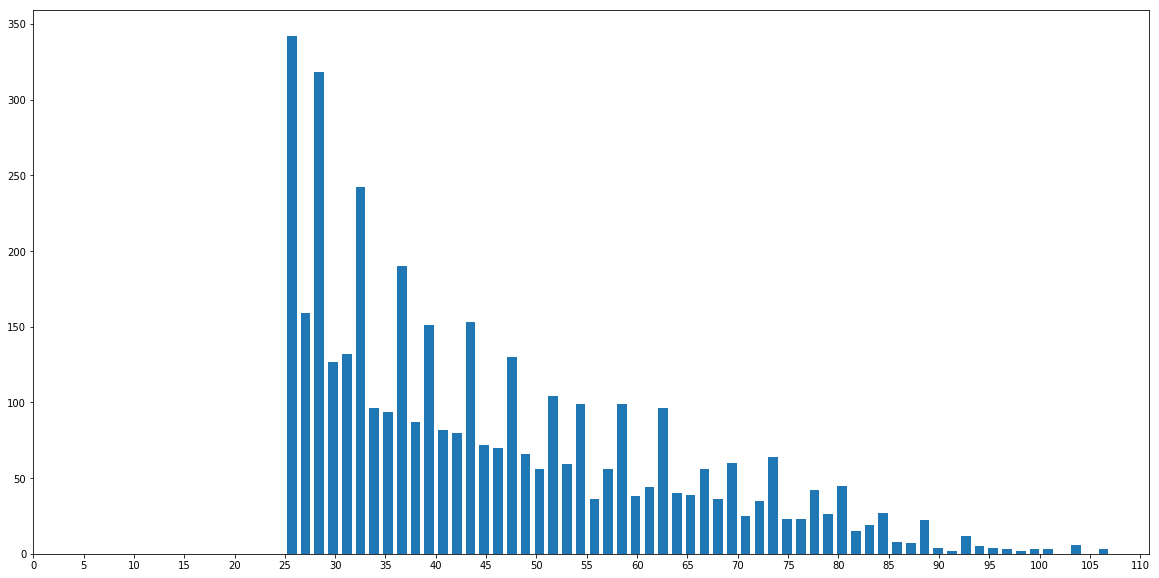

In [91]:
plt.figure(figsize=(20, 10))

hist, bins = np.histogram(lenghts, bins = 60)

width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.xticks(np.arange(0, max(lenghts)+5, 5)  )
plt.show()

In [93]:
lenghts = []
for lc in light_curves:
    lenghts.append(len(lc))

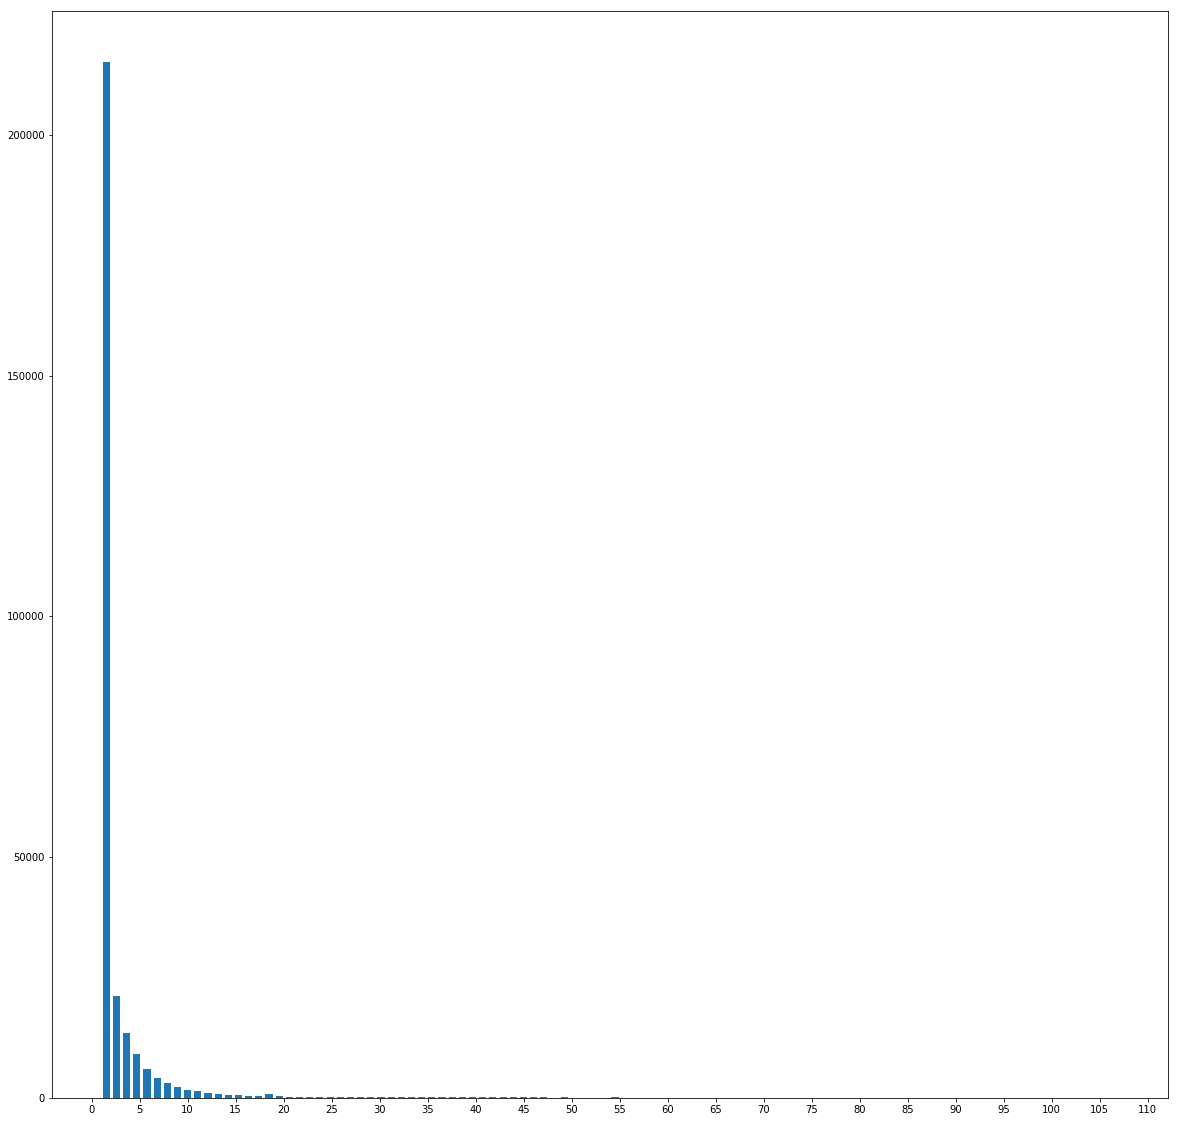

In [96]:
plt.figure(figsize=(20, 20))

hist, bins = np.histogram(lenghts, bins = 100)

width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.xticks(np.arange(0, max(lenghts)+5, 5)  )
plt.show()

In [98]:
lenghts = []
for lc in light_curves:
    if len(lc) >= 10:
        lenghts.append(len(lc))

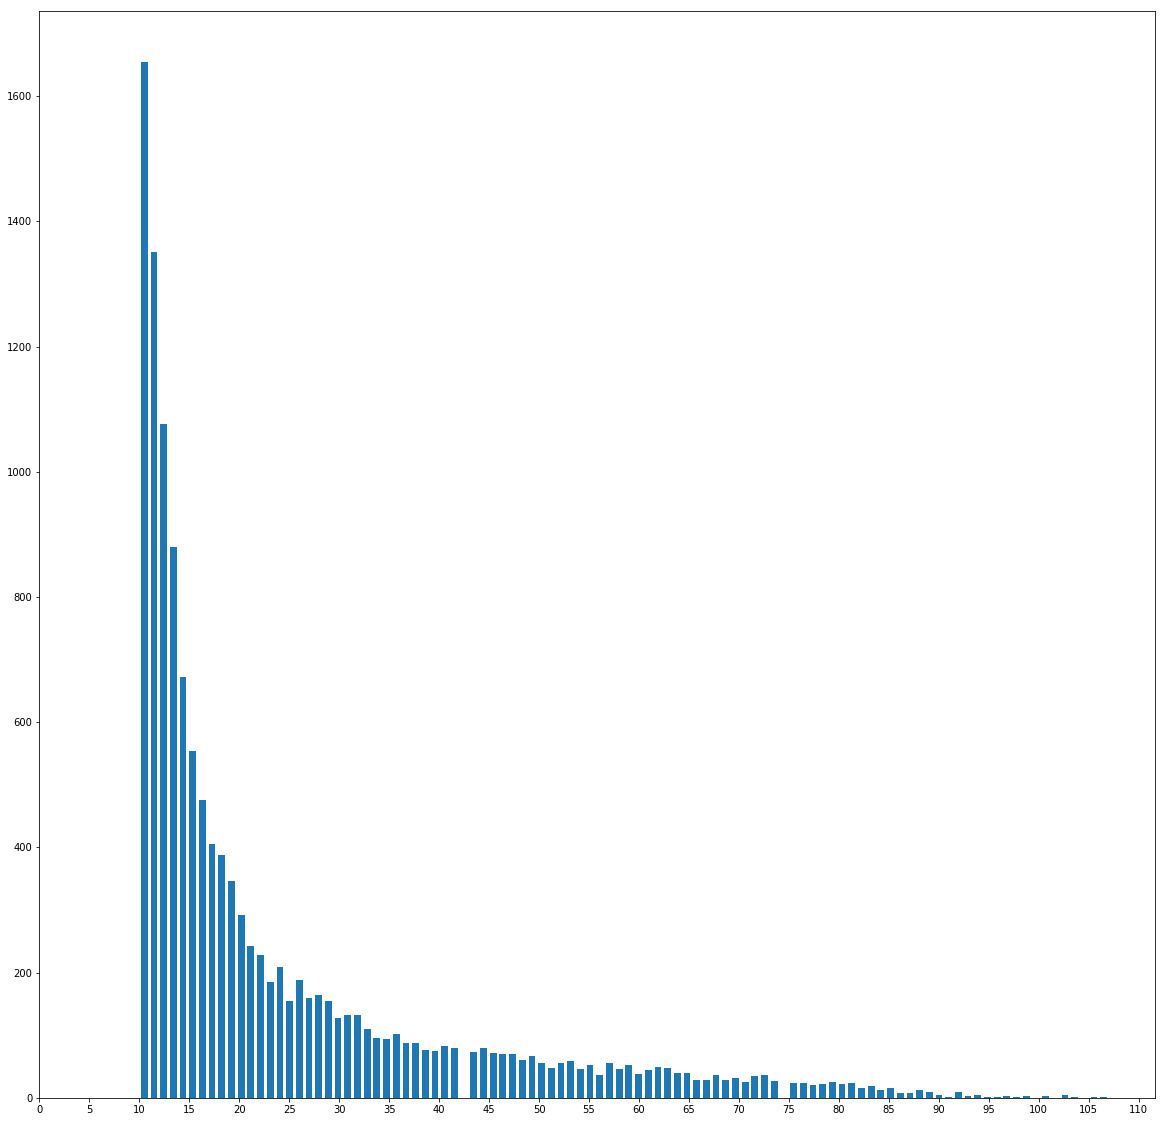

In [99]:
plt.figure(figsize=(20, 20))

hist, bins = np.histogram(lenghts, bins = 100)

width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.xticks(np.arange(0, max(lenghts)+5, 5)  )
plt.show()